#Mount Google

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/lastfm_union.parquet'
import pandas as pd
df = pd.read_parquet(file_path)
print(df.head())
print("\nColumns:", df.columns)
print("Rows:", len(df))

Mounted at /content/drive
       user_id                 timestamp  \
0  user_000001 2009-05-04 23:08:57+00:00   
1  user_000001 2009-05-04 13:54:10+00:00   
2  user_000001 2009-05-04 13:52:04+00:00   
3  user_000001 2009-05-04 13:42:52+00:00   
4  user_000001 2009-05-04 13:42:11+00:00   

                              artist_id   artist_name track_id  \
0  f1b1cf71-bd35-4e99-8624-24a6e15f133a     Deep Dish     None   
1  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   
2  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   
3  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   
4  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   

                                   track_name gender  age country registered  
0  Fuck Me Im Famous (Pacha Ibiza)-09-28-2007      M  NaN   JAPAN 2006-08-13  
1           Composition 0919 (Live_2009_4_15)      M  NaN   JAPAN 2006-08-13  
2                        Mc2 (Live_2009_4_15)      M  NaN   JAPAN 2006-08-1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

#Load the  Last.fm Dataset

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
try:
    df = pd.read_parquet('/content/drive/MyDrive/lastfm_union.parquet')
except:
    try:
        df = pd.read_parquet('/content/drive/MyDrive/datasets/lastfm_union.parquet')
    except:
        try:
            df = pd.read_parquet('/content/drive/MyDrive/data/lastfm_union.parquet')
        except:
            print("File not found. Please specify the correct path.")
            print("List files in MyDrive:")
            import os
            print(os.listdir('/content/drive/MyDrive/'))

print(df.head())
print("\nColumns:", df.columns)
print("Rows:", len(df))
df = df.rename(columns={
    "user_id": "user",
    "track_id": "item",
    "timestamp": "time"
})
df = df.sort_values(["user", "time"])

print("Unique users:", df["user"].nunique())
print("Unique items:", df["item"].nunique())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
       user_id                 timestamp  \
0  user_000001 2009-05-04 23:08:57+00:00   
1  user_000001 2009-05-04 13:54:10+00:00   
2  user_000001 2009-05-04 13:52:04+00:00   
3  user_000001 2009-05-04 13:42:52+00:00   
4  user_000001 2009-05-04 13:42:11+00:00   

                              artist_id   artist_name track_id  \
0  f1b1cf71-bd35-4e99-8624-24a6e15f133a     Deep Dish     None   
1  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   
2  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   
3  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   
4  a7f7df4a-77d8-4f12-8acd-5c60c93f4de8  åæ¬é¾ä¸     None   

                                   track_name gender  age country registered  
0  Fuck Me Im Famous (Pacha Ibiza)-09-28-2007      M  NaN   JAPAN 2006-08-13  
1           Composition 0919 (Live_2009_4_15)      

In [ ]:
df = df.rename(columns={
    "user_id": "user",
    "track_id": "item",
    "timestamp": "time"
})

#Sort & Inspect Raw Interactions

In [ ]:
df = df.sort_values(["user", "time"])

print("Unique users:", df["user"].nunique())
print("Unique items:", df["item"].nunique())


Unique users: 992
Unique items: 960402


#Session Construction:

A new session starts when the inactivity gap > 30 minutes (1800 seconds)

In [ ]:
df["time_diff_sec"] = df.groupby("user")["time"].diff().dt.total_seconds()

df["new_session"] = (
    (df["time_diff_sec"] > 1800) |
    (df["time_diff_sec"].isna())
)

df["session_id"] = df["new_session"].cumsum()


#Build Session Sequences

In [ ]:
sessions = (
    df.groupby("session_id")
      .apply(lambda x: x.sort_values("time")["item"].tolist())
)

session_time = df.groupby("session_id")["time"].max()

print("Total sessions:", len(sessions))

Total sessions: 908878


#Mandatory Filtering

Minimum session length ≥ 2

In [ ]:
sessions = sessions[sessions.apply(len) >= 2]
print("Sessions after length filtering:", len(sessions))

Sessions after length filtering: 803740


Minimum item frequency ≥ 5

In [ ]:
item_freq = Counter(item for s in sessions for item in s)
valid_items = {i for i, c in item_freq.items() if c >= 5}

sessions = sessions.apply(lambda s: [i for i in s if i in valid_items])
sessions = sessions[sessions.apply(len) >= 2]

print("Sessions after item filtering:", len(sessions))

Sessions after item filtering: 792024


#Temporal Train

In [ ]:
session_df = pd.DataFrame({
    "session": sessions,
    "time": session_time.loc[sessions.index]
}).sort_values("time")

n = len(session_df)
train_df = session_df.iloc[:int(0.7*n)]
val_df   = session_df.iloc[int(0.7*n):int(0.85*n)]
test_df  = session_df.iloc[int(0.85*n):]

print("Train:", len(train_df))
print("Validation:", len(val_df))
print("Test:", len(test_df))

Train: 554416
Validation: 118804
Test: 118804


#Important Plots

Session Length Distribution

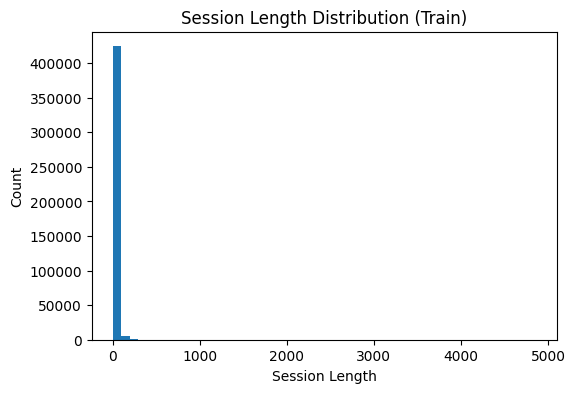

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(train_df["session"].apply(len), bins=50)
plt.title("Session Length Distribution (Train)")
plt.xlabel("Session Length")
plt.ylabel("Count")
plt.show()

Item Popularity Distribution

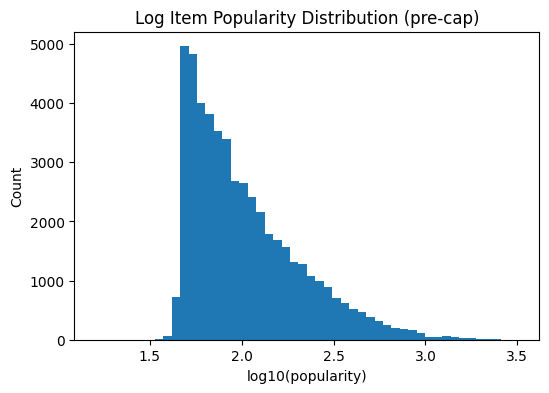

In [ ]:
popularity_pre = Counter(item for s in train_df["session"] for item in s)

plt.figure(figsize=(6,4))
plt.hist(np.log10(list(popularity_pre.values())), bins=50)
plt.title("Log Item Popularity Distribution (pre-cap)")
plt.xlabel("log10(popularity)")
plt.ylabel("Count")
plt.show()


#Descriptive Feature Engineering

In [ ]:
import numpy as np
import pandas as pd

def compute_session_features(df_sessions, popularity_counter):
    pop_values = np.fromiter(popularity_counter.values(), dtype=np.int64)
    pop_90 = np.percentile(pop_values, 90) if len(pop_values) else 0

    rows = []
    for s in df_sessions["session"]:
        pops = [popularity_counter.get(i, 0) for i in s]
        rows.append({
            "length": len(s),
            "unique_items": len(set(s)),
            "avg_popularity": float(np.mean(pops)) if pops else 0.0,
            "max_popularity": float(np.max(pops)) if pops else 0.0,
            "popularity_share": float(np.mean([p >= pop_90 for p in pops])) if pops else 0.0,
            "first_item_pop": float(pops[0]) if pops else 0.0,
            "last_item_pop": float(pops[-1]) if pops else 0.0,
        })
    return pd.DataFrame(rows)


#Session-Based KNN

Vectorization

In [ ]:
train_df["session"] = train_df["session"].apply(lambda s: [str(x) for x in s if pd.notna(x)])
val_df["session"]   = val_df["session"].apply(lambda s: [str(x) for x in s if pd.notna(x)])
test_df["session"]  = test_df["session"].apply(lambda s: [str(x) for x in s if pd.notna(x)])

train_df = train_df[train_df["session"].apply(len) >= 2].copy()
val_df   = val_df[val_df["session"].apply(len) >= 2].copy()
test_df  = test_df[test_df["session"].apply(len) >= 2].copy()

print("After cleaning:")
print("train sessions:", len(train_df))
print("val sessions:  ", len(val_df))
print("test sessions: ", len(test_df))


After cleaning:
train sessions: 430976
val sessions:   81475
test sessions:  75900


In [ ]:
from collections import Counter

item_freq = Counter(i for s in train_df["session"] for i in s)

TOP_N_ITEMS = 50000
top_items = set([i for i, _ in item_freq.most_common(TOP_N_ITEMS)])

train_df["session"] = train_df["session"].apply(lambda s: [i for i in s if i in top_items])
val_df["session"]   = val_df["session"].apply(lambda s: [i for i in s if i in top_items])
test_df["session"]  = test_df["session"].apply(lambda s: [i for i in s if i in top_items])

train_df = train_df[train_df["session"].apply(len) >= 2].copy()
val_df   = val_df[val_df["session"].apply(len) >= 2].copy()
test_df  = test_df[test_df["session"].apply(len) >= 2].copy()

print("After vocab cap:")
print("Train sessions:", len(train_df), " Val:", len(val_df), " Test:", len(test_df))
print("Unique items kept:", len(top_items))

After vocab cap:
Train sessions: 430976  Val: 81475  Test: 75900
Unique items kept: 50000


In [ ]:
pop_values = list(popularity.values())
pop_90 = np.percentile(pop_values, 90)

feature_rows = []

for s in train_df["session"]:
    pops = [popularity[i] for i in s]
    feature_rows.append({
        "length": len(s),
        "unique_items": len(set(s)),
        "avg_popularity": np.mean(pops),
        "max_popularity": np.max(pops),
        "popularity_share": np.mean([p >= pop_90 for p in pops]),
        "first_item_pop": pops[0],
        "last_item_pop": pops[-1]
    })

feature_df = pd.DataFrame(feature_rows)
print(feature_df.describe())

              length   unique_items  avg_popularity  max_popularity  \
count  430976.000000  430976.000000   430976.000000   430976.000000   
mean       16.341223      13.299010      308.197407      783.735642   
std        37.844964      21.520622      240.253275      652.156932   
min         2.000000       1.000000       16.000000       16.000000   
25%         4.000000       4.000000      143.000000      268.000000   
50%         8.000000       8.000000      246.973986      595.000000   
75%        17.000000      15.000000      396.197541     1123.000000   
max      4860.000000    2108.000000     2840.000000     3203.000000   

       popularity_share  first_item_pop  last_item_pop  
count     430976.000000   430976.000000  430976.000000  
mean           0.335610      323.863786     296.287436  
std            0.304452      384.533170     355.875697  
min            0.000000       16.000000      16.000000  
25%            0.000000       87.000000      81.000000  
50%            0.2

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

mlb = MultiLabelBinarizer(sparse_output=True)

X_train = mlb.fit_transform(train_df["session"].tolist()).tocsr().astype(np.float32)
X_val   = mlb.transform(val_df["session"].tolist()).tocsr().astype(np.float32)
X_test  = mlb.transform(test_df["session"].tolist()).tocsr().astype(np.float32)

print("Train matrix shape:", X_train.shape)
print("Train nnz (non-zeros):", X_train.nnz)
print("Num items (vocab actually used):", len(mlb.classes_))


Train matrix shape: (430976, 50000)
Train nnz (non-zeros): 5731554
Num items (vocab actually used): 50000


Recommendation Logic (Neighborhood-Based)

In [ ]:
def recommend_knn(session_vec, seen_items, X_ref, sessions_ref, k=100, top_k=20):
    sims = cosine_similarity(session_vec.reshape(1, -1), X_ref)[0]
    neighbors = np.argsort(sims)[-k:]

    scores = defaultdict(float)
    for idx in neighbors:
        for item in sessions_ref.iloc[idx]:
            if item not in seen_items:
                scores[item] += sims[idx]

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [i for i, _ in ranked[:top_k]]

#Evaluation Metrics

In [ ]:
MAX_TRAIN_FOR_KNN = 50000
MAX_TEST_EVAL = 5000

train_ref = train_df.iloc[:MAX_TRAIN_FOR_KNN].copy()
X_train_ref = X_train[:MAX_TRAIN_FOR_KNN]

test_eval = test_df.sample(n=min(MAX_TEST_EVAL, len(test_df)), random_state=42).copy()

print("Using train_ref:", len(train_ref))
print("Evaluating test_eval:", len(test_eval))


Using train_ref: 50000
Evaluating test_eval: 5000


In [ ]:
feature_ref = feature_df.iloc[:len(train_ref)].reset_index(drop=True)
heuristic_importance_ref = feature_ref["length"].to_numpy()
print("feature_ref shape:", feature_ref.shape)


In [ ]:
from sklearn.preprocessing import normalize

X_train_ref = normalize(X_train_ref, norm="l2", axis=1, copy=False)
print("Normalized X_train_ref. nnz:", X_train_ref.nnz)

Normalized X_train_ref. nnz: 654786


In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import normalize

def recommend_knn(session_vec, seen_items, X_ref, sessions_ref, k=100, top_k=20):
    session_vec = normalize(session_vec, norm="l2", axis=1, copy=False)

    sims_sparse = (X_ref @ session_vec.T).tocoo()
    if sims_sparse.nnz == 0:
        return []

    rows = sims_sparse.row
    vals = sims_sparse.data

    if len(vals) > k:
        top_idx = np.argpartition(vals, -k)[-k:]
        neigh_rows = rows[top_idx]
        neigh_vals = vals[top_idx]
    else:
        neigh_rows = rows
        neigh_vals = vals

    scores = defaultdict(float)
    for idx, sim in zip(neigh_rows, neigh_vals):
        for item in sessions_ref.iloc[idx]:
            if item not in seen_items:
                scores[item] += float(sim)

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [i for i, _ in ranked[:top_k]]

In [ ]:
import numpy as np

def evaluate(df_eval):
    recall, mrr, ndcg = [], [], []

    for s in df_eval["session"]:
        prefix, target = s[:-1], s[-1]
        vec = mlb.transform([prefix])
        preds = recommend_knn(vec, set(prefix), X_train_ref, train_ref["session"], k=100, top_k=20)

        recall.append(int(target in preds))
        mrr.append(1/(preds.index(target)+1) if target in preds else 0)
        ndcg.append(1/np.log2(preds.index(target)+2) if target in preds else 0)

    return np.mean(recall), np.mean(mrr), np.mean(ndcg)

baseline_scores = evaluate(test_eval)
print("Baseline (subset) Recall@20, MRR@20, NDCG@20:", baseline_scores)

Baseline (subset) Recall@20, MRR@20, NDCG@20: (np.float64(0.1634), np.float64(0.06700843947074596), np.float64(0.08860424345519193))


#Data Importance Methods

Random Baseline

In [ ]:
random_importance_ref = np.random.rand(len(train_ref))


Heuristic Importance (Session Length)

In [ ]:
heuristic_importance_ref = feature_ref["length"].values


Leave-One-Out

Define a val subset

In [ ]:
VAL_EVAL_N = 1000
val_eval = val_df.sample(n=min(VAL_EVAL_N, len(val_df)), random_state=42).copy()
print("Val subset for LOO:", len(val_eval))

Val subset for LOO: 1000


Choose LOO

Compute base score once

In [ ]:
base_recall = evaluate(val_eval)[0]
print("Base Recall@20 (val subset):", base_recall)

Base Recall@20 (val subset): 0.138


#KMC-Shapley

In [ ]:
N_SHAP_TRAIN = 5000
N_SHAP_VAL = 2000
M = 60
train_ref = train_ref.reset_index(drop=True)
shap_train = train_ref.sample(n=N_SHAP_TRAIN, random_state=42)
sample_idx = shap_train.index.to_numpy()
X_shap_train = X_train_ref[sample_idx]
shap_train = shap_train.reset_index(drop=True)
shap_val = val_df.sample(n=N_SHAP_VAL, random_state=42).reset_index(drop=True)

print("Shap train:", len(shap_train), "Shap val:", len(shap_val))
print("X_shap_train shape:", X_shap_train.shape)

Shap train: 5000 Shap val: 2000
X_shap_train shape: (5000, 50000)


In [ ]:
checkpoints = [200, 400, 800, 1600, 3200, N_SHAP_TRAIN]

In [ ]:
assert len(shap_train) == X_shap_train.shape[0]
shap_train_ref_idx = sample_idx.copy()


In [ ]:
LOO_N = 200
loo_candidates = np.random.choice(shap_train_ref_idx, size=min(LOO_N, len(shap_train_ref_idx)), replace=False)

loo_scores = {}
for ridx in loo_candidates:
    keep_mask = np.ones(len(train_ref), dtype=bool)
    keep_mask[ridx] = False

    X_ref_loo = X_train_ref[keep_mask]
    sessions_ref_loo = train_ref.loc[keep_mask, "session"].reset_index(drop=True)

    recall = []
    for s in val_eval["session"]:
        prefix, target = s[:-1], s[-1]
        vec = mlb.transform([prefix])
        preds = recommend_knn(vec, set(prefix), X_ref_loo, sessions_ref_loo, k=100, top_k=20)
        recall.append(int(target in preds))

    loo_scores[ridx] = float(base_recall - np.mean(recall))

loo_trainref = pd.Series(loo_scores)
print("LOO computed for:", len(loo_trainref), "sessions. Example:", loo_trainref.head())


LOO computed for: 200 sessions. Example: 6648     0.0
8344     0.0
37765    0.0
20457    0.0
26403    0.0
dtype: float64


In [ ]:
shapley = np.zeros(N_SHAP_TRAIN)

for _ in range(M):
    perm = np.random.permutation(N_SHAP_TRAIN)
    prev_score = 0.0
    prev_t = 0

    for t in checkpoints:
        idxs = perm[:t]
        X_ref_tmp = X_shap_train[idxs]
        sess_ref_tmp = shap_train["session"].iloc[idxs].reset_index(drop=True)

        recall = []
        for s in shap_val["session"]:
            prefix, target = s[:-1], s[-1]
            vec = mlb.transform([prefix])
            preds = recommend_knn(vec, set(prefix), X_ref_tmp, sess_ref_tmp, k=100, top_k=20)
            recall.append(int(target in preds))

        score = float(np.mean(recall))
        delta = score - prev_score
        block = perm[prev_t:t]
        shapley[block] += delta / len(block)

        prev_score = score
        prev_t = t

shapley /= M
print("Shapley stats:", shapley.min(), shapley.mean(), shapley.max())
print("Nonzero:", np.count_nonzero(shapley), "/", len(shapley))

Shapley stats: 1.3669560185185183e-05 1.749333333333333e-05 2.1961226851851857e-05
Nonzero: 5000 / 5000


#Data Debugging Experiments and Plot

In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_with_ref(df_eval, X_ref, sessions_ref, kNN=100, topK=20):
    recalls, mrrs, ndcgs = [], [], []
    sessions_ref = sessions_ref.reset_index(drop=True)

    for s in df_eval["session"]:
        prefix, target = s[:-1], s[-1]
        vec = mlb.transform([prefix])[0]
        seen = set(prefix)

        sims = cosine_similarity(vec.reshape(1, -1), X_ref)[0]
        neighbors = np.argsort(sims)[-kNN:]

        scores = defaultdict(float)
        for idx in neighbors:
            sim = sims[idx]
            for it in sessions_ref.iloc[idx]:
                if it not in seen:
                    scores[it] += sim

        preds = [it for it, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topK]]

        recalls.append(int(target in preds))
        mrrs.append(1/(preds.index(target)+1) if target in preds else 0)
        ndcgs.append(1/np.log2(preds.index(target)+2) if target in preds else 0)

    return float(np.mean(recalls)), float(np.mean(mrrs)), float(np.mean(ndcgs))

In [ ]:
import numpy as np
fractions = [0.0, 0.01]
test_small = test_df.sample(n=2000, random_state=42)
trials = 3
baseR, baseMRR, baseNDCG = evaluate_with_ref(test_small, X_train_ref, train_ref["session"])
print("BASELINE (train_ref) Recall@20:", baseR, "MRR@20:", baseMRR, "NDCG@20:", baseNDCG)

shapley_trainref = pd.Series(shapley, index=shap_train_ref_idx)

low_order_ref  = shapley_trainref.sort_values(ascending=True).index.to_numpy()
high_order_ref = shapley_trainref.sort_values(ascending=False).index.to_numpy()

lowR, highR = [], []
rand_mean, rand_std = [], []

for f in fractions:
    k = int(len(low_order_ref) * f)
    keep_mask = np.ones(len(train_ref), dtype=bool)
    if k > 0:
        keep_mask[low_order_ref[:k]] = False

    R_low = evaluate_with_ref(
        test_small,
        X_train_ref[keep_mask],
        train_ref.loc[keep_mask, "session"].reset_index(drop=True)
    )[0]
    lowR.append(R_low)
    print(f"Remove LOW  {int(f*100)}% of scored -> Recall@20:", R_low)
    keep_mask = np.ones(len(train_ref), dtype=bool)
    if k > 0:
        keep_mask[high_order_ref[:k]] = False

    R_high = evaluate_with_ref(
        test_small,
        X_train_ref[keep_mask],
        train_ref.loc[keep_mask, "session"].reset_index(drop=True)
    )[0]
    highR.append(R_high)
    print(f"Remove HIGH {int(f*100)}% of scored -> Recall@20:", R_high)
    if k == 0:
        rand_mean.append(baseR)
        rand_std.append(0.0)
        continue

    scores = []
    for _ in range(trials):
        removed = np.random.choice(shap_train_ref_idx, size=k, replace=False)
        keep_mask = np.ones(len(train_ref), dtype=bool)
        keep_mask[removed] = False

        scores.append(evaluate_with_ref(
            test_small,
            X_train_ref[keep_mask],
            train_ref.loc[keep_mask, "session"].reset_index(drop=True)
        )[0])

    rand_mean.append(float(np.mean(scores)))
    rand_std.append(float(np.std(scores)))
    print(f"Random      {int(f*100)}% of scored -> Recall@20 mean±std:", rand_mean[-1], "±", rand_std[-1])


BASELINE (train_ref) Recall@20: 0.1665 MRR@20: 0.06638485791813965 NDCG@20: 0.08898961213183057
Remove LOW  0% of scored -> Recall@20: 0.1665
Remove HIGH 0% of scored -> Recall@20: 0.1665
Remove LOW  1% of scored -> Recall@20: 0.167
Remove HIGH 1% of scored -> Recall@20: 0.167
Random      1% of scored -> Recall@20 mean±std: 0.16666666666666666 ± 0.00023570226039551604


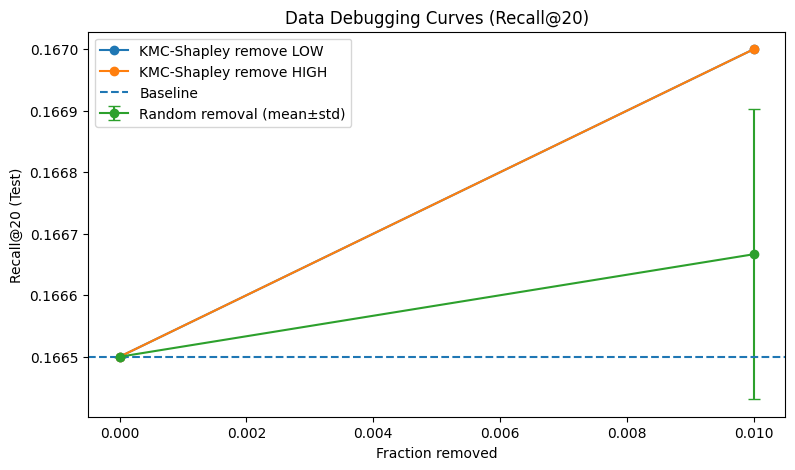

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(fractions, lowR, marker="o", label="KMC-Shapley remove LOW")
plt.plot(fractions, highR, marker="o", label="KMC-Shapley remove HIGH")
plt.errorbar(fractions, rand_mean, yerr=rand_std, marker="o", capsize=4, label="Random removal (mean±std)")
plt.axhline(baseR, linestyle="--", label="Baseline")
plt.xlabel("Fraction removed")
plt.ylabel("Recall@20 (Test)")
plt.title("Data Debugging Curves (Recall@20)")
plt.legend()
plt.show()

Histogram of importance scores

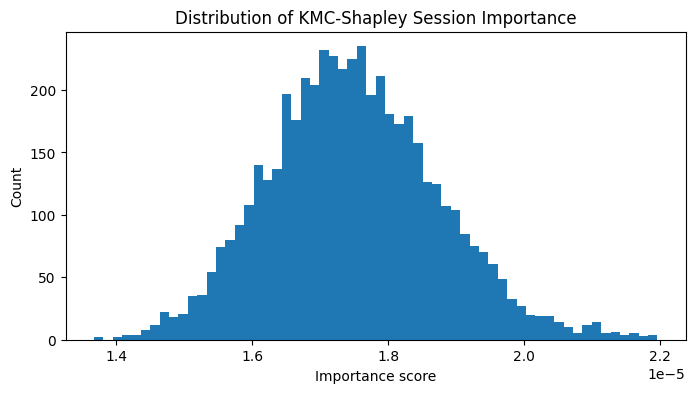

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(shapley, bins=60)
plt.title("Distribution of KMC-Shapley Session Importance")
plt.xlabel("Importance score")
plt.ylabel("Count")
plt.show()

Compare Random vs Heuristic vs Shapley score distributions

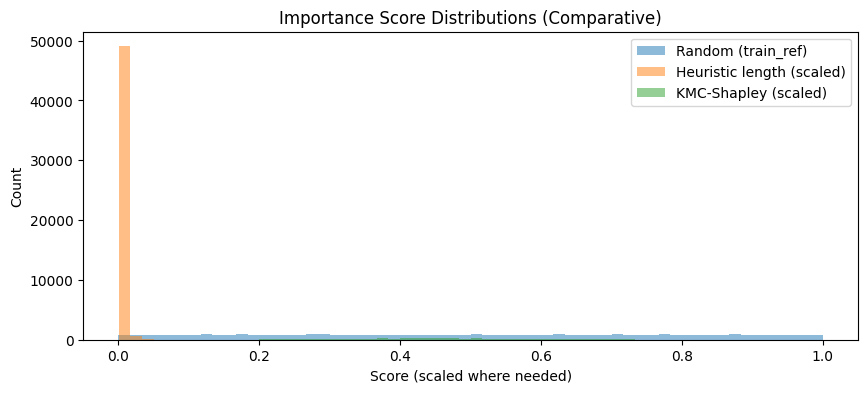

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(random_importance_ref, bins=60, alpha=0.5, label="Random (train_ref)")

plt.hist(
    heuristic_importance_ref / (heuristic_importance_ref.max() + 1e-12),
    bins=60, alpha=0.5, label="Heuristic length (scaled)"
)

plt.hist(
    (shapley - shapley.min()) / (shapley.max() - shapley.min() + 1e-12),
    bins=60, alpha=0.5, label="KMC-Shapley (scaled)"
)

plt.title("Importance Score Distributions (Comparative)")
plt.xlabel("Score (scaled where needed)")
plt.ylabel("Count")
plt.legend()
plt.show()


Feature vs Importance

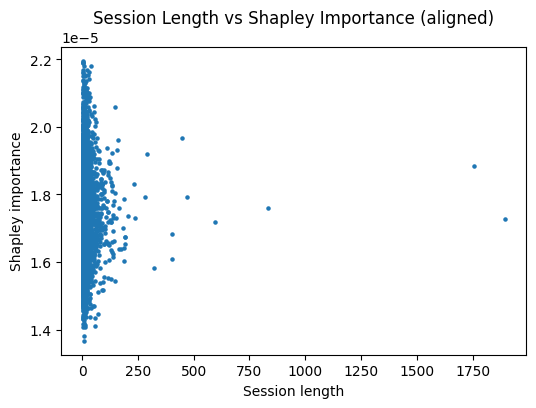

In [ ]:
feature_sample = feature_ref.loc[shap_train_ref_idx].reset_index(drop=True)

plt.figure(figsize=(6,4))
plt.scatter(feature_sample["length"], shapley, s=5)
plt.title("Session Length vs Shapley Importance (aligned)")
plt.xlabel("Session length")
plt.ylabel("Shapley importance")
plt.show()

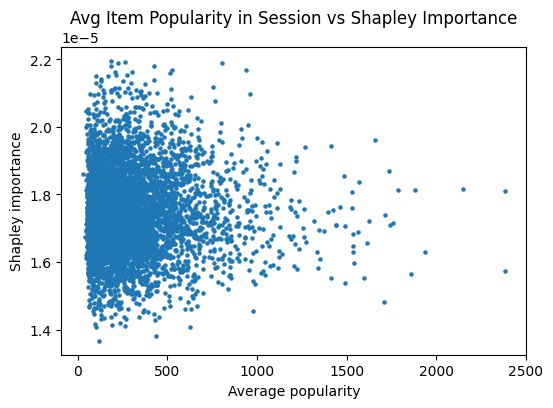

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(feature_sample["avg_popularity"], shapley, s=5)
plt.title("Avg Item Popularity in Session vs Shapley Importance")
plt.xlabel("Average popularity")
plt.ylabel("Shapley importance")
plt.show()

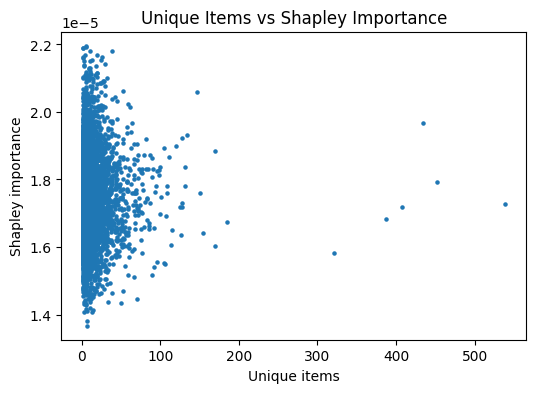

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(feature_sample["unique_items"], shapley, s=5)
plt.title("Unique Items vs Shapley Importance")
plt.xlabel("Unique items")
plt.ylabel("Shapley importance")
plt.show()

Qualitative analysis (must include examples, not only plots

In [ ]:
shapley_trainref = pd.Series(shapley, index=shap_train_ref_idx)

top_ref_idx = shapley_trainref.nlargest(5).index
low_ref_idx = shapley_trainref.nsmallest(5).index

print("TOP 5 HELPFUL SESSIONS (by Shapley, mapped to train_ref)")
for ridx in top_ref_idx:
    s = train_ref.loc[ridx, "session"]
    feats = feature_ref.loc[ridx].to_dict()
    print("\nShapley:", float(shapley_trainref.loc[ridx]))
    print("Features:", feats)
    print("Session (first 20 items):", s[:20])

print("\n\nTOP 5 HARMFUL SESSIONS (by Shapley, mapped to train_ref)")
for ridx in low_ref_idx:
    s = train_ref.loc[ridx, "session"]
    feats = feature_ref.loc[ridx].to_dict()
    print("\nShapley:", float(shapley_trainref.loc[ridx]))
    print("Features:", feats)
    print("Session (first 20 items):", s[:20])

TOP 5 HELPFUL SESSIONS (by Shapley, mapped to train_ref)

Shapley: 2.1961226851851857e-05
Features: {'length': 6.0, 'unique_items': 6.0, 'avg_popularity': 185.16666666666666, 'max_popularity': 299.0, 'popularity_share': 0.16666666666666666, 'first_item_pop': 72.0, 'last_item_pop': 107.0}
Session (first 20 items): ['5eefb449-0dca-4784-895c-40190093f1fa', '8ec90eca-3f1e-4c7c-befa-042161c97782', 'b5605b34-b54c-4764-92be-3d3a07ae677b', '814601da-af9c-4ab6-b7c6-79b357b92eda', '78640086-fe92-4c4b-b500-3c9864d55bd8', 'd8e53f01-b574-41fc-8f92-48c8ca5ea234']

Shapley: 2.1910300925925917e-05
Features: {'length': 5.0, 'unique_items': 5.0, 'avg_popularity': 265.8, 'max_popularity': 494.0, 'popularity_share': 0.2, 'first_item_pop': 171.0, 'last_item_pop': 190.0}
Session (first 20 items): ['63037d2d-5369-4f07-9d0b-395060fadccc', '4c8aeefb-02c9-4490-99df-5d447fc227da', 'cf8d54e9-7db0-40e9-8d51-342268447e51', '8f9056f9-7349-47c8-a0ee-f21100ca7048', '662f2270-27d7-4672-bb8d-b8d3b72a29d8']

Shapley: 2.1

#Qualitative Analysis

In [ ]:
top_sessions = train_df.iloc[np.argsort(shapley)[-5:]]
bad_sessions = train_df.iloc[np.argsort(shapley)[:5]]

print("High-importance sessions:")
print(top_sessions["session"])

print("\nLow-importance (harmful) sessions:")
print(bad_sessions["session"])

High-importance sessions:
session_id
754603    [4ab5d32e-27ef-449f-a109-d9b061e9a10d, e2aee5f...
484712    [d0a2c360-1cda-4a7e-a456-36b0b7495dc8, 799f2d7...
293194    [3c8f28a3-a1bb-4827-9f77-8d86edcd3248, 70b81a9...
874700    [6efdd76d-81c2-4685-bae8-f7a752e2ae1c, 69c133a...
605572    [ff888609-4331-47b6-8f27-90f5b47ece65, 74400b7...
Name: session, dtype: object

Low-importance (harmful) sessions:
session_id
329734    [71b27f17-7168-426c-af84-acad55083a88, 8803e15...
279760    [8652292b-31b3-4839-9532-f2b700a0a7cc, 7f2121b...
284940    [7a7fbad3-2e2d-4c44-82c1-e15ce3160a4e, 979459d...
615562    [068e6bf7-d50c-4923-bb62-ebafd4f03492, ff4ef84...
635154    [d5050499-3035-4daf-8493-ba0aafe1836d, 54727d7...
Name: session, dtype: object
